In [1]:
from sympy import *
init_printing(use_latex='mathjax')

In [2]:
import re

## Set up tensors so that we may use reasonable math notation

In [3]:
from sympy import MutableDenseNDimArray as MArray

In [4]:
class MyMArray(MArray):
    
    def __mul__(self, other):
        try:
            return super().__mul__(other)
        except ValueError:
            if not isinstance(other, MyMArray):
                raise ValueError("Need MyMArray for contraction")
            
            rank_self = self.rank()
            prod = tensorproduct(self, other)
            return MyMArray( tensorcontraction(prod, (rank_self - 1, rank_self)) )
    
    def __matmul__(self, other):
        try:
            return super().__mul__(other)
        except ValueError:
            if not isinstance(other, MyMArray):
                raise ValueError("Need MyMArray for tensor product")

            return MyMArray( tensorproduct(self, other) )
    
    def __pow__(self, other):
        try:
            return super().__mul__(other)
        except ValueError:
            if not isinstance(other, MyMArray):
                raise ValueError("Need MyMArray for double contraction")

            rank_self = self.rank()
            prod = tensorproduct(self, other)
            contract = tensorcontraction(prod, (rank_self - 1, rank_self))
            return MyMArray( tensorcontraction(contract, (rank_self - 2, rank_self - 1)) )
        
    def ip(self, other):
        if not isinstance(other, MyMArray):
            raise ValueError("Need MyMArray for inner product")
        
        rank_self = self.rank()
        prod = tensorproduct(self, other)
        while rank_self > 0:
            prod = tensorcontraction(prod, (0, rank_self))
            rank_self -= 1
            
        return prod

## Set up necessary objects that weak forms will be written in

In [5]:
vec_dim = 5
mat_dim = 3

x, y, z = symbols('x y z')
xi = MyMArray([x, y, z])

alpha, dt, L2, L3 = symbols(r'\alpha \delta\ t L_2 L_3')

Q_vec = zeros(vec_dim, 1)
for i in range(vec_dim):
    Q_vec[i] = Function('Q_' + str(i + 1))(x, y)
#     Q_vec[i] = Function('Q_' + str(i + 1))(x, y, z)
    
Q0_vec = zeros(vec_dim, 1)
for i in range(vec_dim):
    Q0_vec[i] = Function('Q_{0' + str(i + 1) + '}')(x, y)
#     Q0_vec[i] = Function('Q_{0' + str(i + 1) + '}')(x, y, z)

phi_vec = zeros(vec_dim, 1)
for i in range(vec_dim):
    phi_vec[i] = Function(r'\phi_' + str(i + 1))(x, y)
#     phi_vec[i] = Function(r'\phi_' + str(i + 1))(x, y, z)
    
phi_i = Function(r'\phi_i')(x, y)
phi_j = Function(r'\phi_j')(x, y)
# phi_i = Function(r'\phi_i')(x, y, z)
# phi_j = Function(r'\phi_j')(x, y, z)
    
Lambda_vec = zeros(vec_dim, 1)
for i in range(vec_dim):
    Lambda_vec[i] = Function(r'\Lambda_' + str(i + 1))(x, y)
#     Lambda_vec[i] = Function(r'\Lambda_' + str(i + 1))(x, y, z)
    
display([alpha, dt, L2, L3])
display(xi)
display(Q_vec)
display(Q0_vec)
display(phi_vec)
display(Lambda_vec)

display(phi_i)
display(phi_j)

[\alpha, \delta t, L₂, L₃]

[x  y  z]

⎡Q₁(x, y)⎤
⎢        ⎥
⎢Q₂(x, y)⎥
⎢        ⎥
⎢Q₃(x, y)⎥
⎢        ⎥
⎢Q₄(x, y)⎥
⎢        ⎥
⎣Q₅(x, y)⎦

⎡Q_{01}(x, y)⎤
⎢            ⎥
⎢Q_{02}(x, y)⎥
⎢            ⎥
⎢Q_{03}(x, y)⎥
⎢            ⎥
⎢Q_{04}(x, y)⎥
⎢            ⎥
⎣Q_{05}(x, y)⎦

⎡\phi₁(x, y)⎤
⎢           ⎥
⎢\phi₂(x, y)⎥
⎢           ⎥
⎢\phi₃(x, y)⎥
⎢           ⎥
⎢\phi₄(x, y)⎥
⎢           ⎥
⎣\phi₅(x, y)⎦

⎡\Lambda₁(x, y)⎤
⎢              ⎥
⎢\Lambda₂(x, y)⎥
⎢              ⎥
⎢\Lambda₃(x, y)⎥
⎢              ⎥
⎢\Lambda₄(x, y)⎥
⎢              ⎥
⎣\Lambda₅(x, y)⎦

\phiᵢ(x, y)

\phi_j(x, y)

## Choose basis

In [6]:
basis = []
basis.append(MyMArray([[1, 0, 0],
                   [0, 0, 0],
                   [0, 0, -1]]))
basis.append(MyMArray([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 0]]))
basis.append(MyMArray([[0, 0, 1],
                   [0, 0, 0],
                   [1, 0, 0]]))
basis.append(MyMArray([[0, 0, 0],
                   [0, 1, 0],
                   [0, 0, -1]]))
basis.append(MyMArray([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0]]))

display(basis)

⎡⎡1  0  0 ⎤  ⎡0  1  0⎤  ⎡0  0  1⎤  ⎡0  0  0 ⎤  ⎡0  0  0⎤⎤
⎢⎢        ⎥  ⎢       ⎥  ⎢       ⎥  ⎢        ⎥  ⎢       ⎥⎥
⎢⎢0  0  0 ⎥, ⎢1  0  0⎥, ⎢0  0  0⎥, ⎢0  1  0 ⎥, ⎢0  0  1⎥⎥
⎢⎢        ⎥  ⎢       ⎥  ⎢       ⎥  ⎢        ⎥  ⎢       ⎥⎥
⎣⎣0  0  -1⎦  ⎣0  0  0⎦  ⎣1  0  0⎦  ⎣0  0  -1⎦  ⎣0  1  0⎦⎦

In [7]:
# basis = []
# basis.append(MyMArray([[2/sqrt(3), 0, 0],
#                        [0, -1/sqrt(3), 0],
#                        [0, 0, -1/sqrt(3)]]))
# basis.append(MyMArray([[0, 0, 0],
#                    [0, 1, 0],
#                    [0, 0, -1]]))
# basis.append(MyMArray([[0, 1, 0],
#                    [1, 0, 0],
#                    [0, 0, 0]]))
# basis.append(MyMArray([[0, 0, 1],
#                    [0, 0, 0],
#                    [1, 0, 0]]))
# basis.append(MyMArray([[0, 0, 0],
#                    [0, 0, 1],
#                    [0, 1, 0]]))

# display(basis)

## Construct matrix objects from basis

In [8]:
Q = MyMArray.zeros(mat_dim, mat_dim)
for i in range(vec_dim):
    Q += basis[i]*Q_vec[i]
    
Q0 = MyMArray.zeros(mat_dim, mat_dim)
for i in range(vec_dim):
    Q0 += basis[i]*Q0_vec[i]
    
Lambda = MyMArray.zeros(mat_dim, mat_dim)
for i in range(vec_dim):
    Lambda += basis[i]*Lambda_vec[i]
    
Phi_i = []
for i in range(vec_dim):
    Phi_i.append( MyMArray(basis[i]*phi_i) )
    
Phi_j = []
for i in range(vec_dim):
    Phi_j.append( MyMArray(basis[i]*phi_j) )

display(Q)
display(Lambda)
display(Phi_i)
display(Phi_j)

⎡Q₁(x, y)  Q₂(x, y)        Q₃(x, y)      ⎤
⎢                                        ⎥
⎢Q₂(x, y)  Q₄(x, y)        Q₅(x, y)      ⎥
⎢                                        ⎥
⎣Q₃(x, y)  Q₅(x, y)  -Q₁(x, y) - Q₄(x, y)⎦

⎡\Lambda₁(x, y)  \Lambda₂(x, y)           \Lambda₃(x, y)         ⎤
⎢                                                                ⎥
⎢\Lambda₂(x, y)  \Lambda₄(x, y)           \Lambda₅(x, y)         ⎥
⎢                                                                ⎥
⎣\Lambda₃(x, y)  \Lambda₅(x, y)  -\Lambda₁(x, y) - \Lambda₄(x, y)⎦

⎡⎡\phiᵢ(x, y)  0       0      ⎤  ⎡     0       \phiᵢ(x, y)  0⎤  ⎡     0       
⎢⎢                            ⎥  ⎢                           ⎥  ⎢             
⎢⎢     0       0       0      ⎥, ⎢\phiᵢ(x, y)       0       0⎥, ⎢     0       
⎢⎢                            ⎥  ⎢                           ⎥  ⎢             
⎣⎣     0       0  -\phiᵢ(x, y)⎦  ⎣     0            0       0⎦  ⎣\phiᵢ(x, y)  

0  \phiᵢ(x, y)⎤  ⎡0       0            0      ⎤  ⎡0       0            0     ⎤
              ⎥  ⎢                            ⎥  ⎢                           ⎥
0       0     ⎥, ⎢0  \phiᵢ(x, y)       0      ⎥, ⎢0       0       \phiᵢ(x, y)⎥
              ⎥  ⎢                            ⎥  ⎢                           ⎥
0       0     ⎦  ⎣0       0       -\phiᵢ(x, y)⎦  ⎣0  \phiᵢ(x, y)       0     ⎦

⎤
⎥
⎥
⎥
⎦

⎡⎡\phi_j(x, y)  0        0      ⎤  ⎡     0        \phi_j(x, y)  0⎤  ⎡     0   
⎢⎢                              ⎥  ⎢                             ⎥  ⎢         
⎢⎢     0        0        0      ⎥, ⎢\phi_j(x, y)       0        0⎥, ⎢     0   
⎢⎢                              ⎥  ⎢                             ⎥  ⎢         
⎣⎣     0        0  -\phi_j(x, y)⎦  ⎣     0             0        0⎦  ⎣\phi_j(x,

     0  \phi_j(x, y)⎤  ⎡0       0              0      ⎤  ⎡0       0           
                    ⎥  ⎢                              ⎥  ⎢                    
     0       0      ⎥, ⎢0  \phi_j(x, y)        0      ⎥, ⎢0       0        \ph
                    ⎥  ⎢                              ⎥  ⎢                    
 y)  0       0      ⎦  ⎣0       0        -\phi_j(x, y)⎦  ⎣0  \phi_j(x, y)     

  0      ⎤⎤
         ⎥⎥
i_j(x, y)⎥⎥
         ⎥⎥
  0      ⎦⎦

In [9]:
grad_Phi_i = []
grad_Phi_j = []
grad_Phi_i_T = []
grad_Phi_j_T = []
div_Phi_i = []
div_Phi_j = []
for i in range(vec_dim):
    grad_Phi_i.append( MyMArray(derive_by_array(Phi_i[i], xi)) )
    grad_Phi_j.append( MyMArray(derive_by_array(Phi_j[i], xi)) )
    
    grad_Phi_i_T.append( permutedims(grad_Phi_i[i], (1, 2, 0)) )
    grad_Phi_j_T.append( permutedims(grad_Phi_i[i], (1, 2, 0)) )
    
    div_Phi_i.append( MyMArray(tensorcontraction(grad_Phi_i[i], (0, 1))) )
    div_Phi_j.append( MyMArray(tensorcontraction(grad_Phi_j[i], (0, 1))) )
    
display(grad_Phi_i)
display(grad_Phi_j)
display(grad_Phi_i_T)
display(grad_Phi_j_T)
display(div_Phi_i)
display(div_Phi_j)

⎡⎡⎡∂                                   ⎤  ⎡∂                                  
⎢⎢⎢──(\phiᵢ(x, y))  0         0        ⎥  ⎢──(\phiᵢ(x, y))  0         0       
⎢⎢⎢∂x                                  ⎥  ⎢∂y                                 
⎢⎢⎢                                    ⎥  ⎢                                   
⎢⎢⎢       0         0         0        ⎥  ⎢       0         0         0       
⎢⎢⎢                                    ⎥  ⎢                                   
⎢⎢⎢                     ∂              ⎥  ⎢                     ∂             
⎢⎢⎢       0         0  -──(\phiᵢ(x, y))⎥  ⎢       0         0  -──(\phiᵢ(x, y)
⎣⎣⎣                     ∂x             ⎦  ⎣                     ∂y            

 ⎤           ⎤  ⎡⎡                 ∂                 ⎤  ⎡                 ∂   
 ⎥           ⎥  ⎢⎢       0         ──(\phiᵢ(x, y))  0⎥  ⎢       0         ──(\
 ⎥  ⎡0  0  0⎤⎥  ⎢⎢                 ∂x                ⎥  ⎢                 ∂y  
 ⎥  ⎢       ⎥⎥  ⎢⎢                                 

⎡⎡⎡∂                                     ⎤  ⎡∂                                
⎢⎢⎢──(\phi_j(x, y))  0          0        ⎥  ⎢──(\phi_j(x, y))  0          0   
⎢⎢⎢∂x                                    ⎥  ⎢∂y                               
⎢⎢⎢                                      ⎥  ⎢                                 
⎢⎢⎢       0          0          0        ⎥  ⎢       0          0          0   
⎢⎢⎢                                      ⎥  ⎢                                 
⎢⎢⎢                      ∂               ⎥  ⎢                      ∂          
⎢⎢⎢       0          0  -──(\phi_j(x, y))⎥  ⎢       0          0  -──(\phi_j(x
⎣⎣⎣                      ∂x              ⎦  ⎣                      ∂y         

     ⎤           ⎤  ⎡⎡                  ∂                  ⎤  ⎡               
     ⎥           ⎥  ⎢⎢       0          ──(\phi_j(x, y))  0⎥  ⎢       0       
     ⎥  ⎡0  0  0⎤⎥  ⎢⎢                  ∂x                 ⎥  ⎢               
     ⎥  ⎢       ⎥⎥  ⎢⎢                             

⎡⎡⎡∂                ∂                 ⎤             ⎡       0                 
⎢⎢⎢──(\phiᵢ(x, y))  ──(\phiᵢ(x, y))  0⎥  ⎡0  0  0⎤  ⎢                         
⎢⎢⎢∂x               ∂y                ⎥  ⎢       ⎥  ⎢       0                 
⎢⎢⎢                                   ⎥  ⎢0  0  0⎥  ⎢                         
⎢⎢⎢       0                0         0⎥  ⎢       ⎥  ⎢ ∂                 ∂     
⎢⎢⎢                                   ⎥  ⎣0  0  0⎦  ⎢-──(\phiᵢ(x, y))  -──(\ph
⎣⎣⎣       0                0         0⎦             ⎣ ∂x                ∂y    

0          0⎤⎤  ⎡⎡       0                0         0⎤  ⎡∂                ∂   
            ⎥⎥  ⎢⎢                                   ⎥  ⎢──(\phiᵢ(x, y))  ──(\
0          0⎥⎥  ⎢⎢∂                ∂                 ⎥  ⎢∂x               ∂y  
            ⎥⎥, ⎢⎢──(\phiᵢ(x, y))  ──(\phiᵢ(x, y))  0⎥  ⎢                     
            ⎥⎥  ⎢⎢∂x               ∂y                ⎥  ⎢       0             
iᵢ(x, y))  0⎥⎥  ⎢⎢                                 

⎡⎡⎡∂                ∂                 ⎤             ⎡       0                 
⎢⎢⎢──(\phiᵢ(x, y))  ──(\phiᵢ(x, y))  0⎥  ⎡0  0  0⎤  ⎢                         
⎢⎢⎢∂x               ∂y                ⎥  ⎢       ⎥  ⎢       0                 
⎢⎢⎢                                   ⎥  ⎢0  0  0⎥  ⎢                         
⎢⎢⎢       0                0         0⎥  ⎢       ⎥  ⎢ ∂                 ∂     
⎢⎢⎢                                   ⎥  ⎣0  0  0⎦  ⎢-──(\phiᵢ(x, y))  -──(\ph
⎣⎣⎣       0                0         0⎦             ⎣ ∂x                ∂y    

0          0⎤⎤  ⎡⎡       0                0         0⎤  ⎡∂                ∂   
            ⎥⎥  ⎢⎢                                   ⎥  ⎢──(\phiᵢ(x, y))  ──(\
0          0⎥⎥  ⎢⎢∂                ∂                 ⎥  ⎢∂x               ∂y  
            ⎥⎥, ⎢⎢──(\phiᵢ(x, y))  ──(\phiᵢ(x, y))  0⎥  ⎢                     
            ⎥⎥  ⎢⎢∂x               ∂y                ⎥  ⎢       0             
iᵢ(x, y))  0⎥⎥  ⎢⎢                                 

⎡⎡∂                    ⎤  ⎡∂                ∂                 ⎤  ⎡      ∂     
⎢⎢──(\phiᵢ(x, y))  0  0⎥, ⎢──(\phiᵢ(x, y))  ──(\phiᵢ(x, y))  0⎥, ⎢0  0  ──(\ph
⎣⎣∂x                   ⎦  ⎣∂y               ∂x                ⎦  ⎣      ∂x    

         ⎤  ⎡   ∂                 ⎤  ⎡      ∂              ⎤⎤
iᵢ(x, y))⎥, ⎢0  ──(\phiᵢ(x, y))  0⎥, ⎢0  0  ──(\phiᵢ(x, y))⎥⎥
         ⎦  ⎣   ∂y                ⎦  ⎣      ∂y             ⎦⎦

⎡⎡∂                     ⎤  ⎡∂                 ∂                  ⎤  ⎡      ∂  
⎢⎢──(\phi_j(x, y))  0  0⎥, ⎢──(\phi_j(x, y))  ──(\phi_j(x, y))  0⎥, ⎢0  0  ──(
⎣⎣∂x                    ⎦  ⎣∂y                ∂x                 ⎦  ⎣      ∂x 

             ⎤  ⎡   ∂                  ⎤  ⎡      ∂               ⎤⎤
\phi_j(x, y))⎥, ⎢0  ──(\phi_j(x, y))  0⎥, ⎢0  0  ──(\phi_j(x, y))⎥⎥
             ⎦  ⎣   ∂y                 ⎦  ⎣      ∂y              ⎦⎦

In [10]:
grad_Q = MyMArray(derive_by_array(Q, xi))
grad_Q_T = permutedims(grad_Q, (1, 2, 0))
div_Q = MyMArray( tensorcontraction(grad_Q, (0, 1)) )

display(grad_Q)
display(grad_Q_T)
display(div_Q)

⎡⎡∂             ∂                     ∂                    ⎤  ⎡∂             ∂
⎢⎢──(Q₁(x, y))  ──(Q₂(x, y))          ──(Q₃(x, y))         ⎥  ⎢──(Q₁(x, y))  ─
⎢⎢∂x            ∂x                    ∂x                   ⎥  ⎢∂y            ∂
⎢⎢                                                         ⎥  ⎢               
⎢⎢∂             ∂                     ∂                    ⎥  ⎢∂             ∂
⎢⎢──(Q₂(x, y))  ──(Q₄(x, y))          ──(Q₅(x, y))         ⎥  ⎢──(Q₂(x, y))  ─
⎢⎢∂x            ∂x                    ∂x                   ⎥  ⎢∂y            ∂
⎢⎢                                                         ⎥  ⎢               
⎢⎢∂             ∂               ∂              ∂           ⎥  ⎢∂             ∂
⎢⎢──(Q₃(x, y))  ──(Q₅(x, y))  - ──(Q₁(x, y)) - ──(Q₄(x, y))⎥  ⎢──(Q₃(x, y))  ─
⎣⎣∂x            ∂x              ∂x             ∂x          ⎦  ⎣∂y            ∂

                     ∂                    ⎤           ⎤
─(Q₂(x, y))          ──(Q₃(x, y))         ⎥           ⎥
y                 

⎡⎡∂             ∂              ⎤  ⎡∂             ∂              ⎤  ⎡        ∂ 
⎢⎢──(Q₁(x, y))  ──(Q₁(x, y))  0⎥  ⎢──(Q₂(x, y))  ──(Q₂(x, y))  0⎥  ⎢        ──
⎢⎢∂x            ∂y             ⎥  ⎢∂x            ∂y             ⎥  ⎢        ∂x
⎢⎢                             ⎥  ⎢                             ⎥  ⎢          
⎢⎢∂             ∂              ⎥  ⎢∂             ∂              ⎥  ⎢        ∂ 
⎢⎢──(Q₂(x, y))  ──(Q₂(x, y))  0⎥  ⎢──(Q₄(x, y))  ──(Q₄(x, y))  0⎥  ⎢        ──
⎢⎢∂x            ∂y             ⎥  ⎢∂x            ∂y             ⎥  ⎢        ∂x
⎢⎢                             ⎥  ⎢                             ⎥  ⎢          
⎢⎢∂             ∂              ⎥  ⎢∂             ∂              ⎥  ⎢  ∂       
⎢⎢──(Q₃(x, y))  ──(Q₃(x, y))  0⎥  ⎢──(Q₅(x, y))  ──(Q₅(x, y))  0⎥  ⎢- ──(Q₁(x,
⎣⎣∂x            ∂y             ⎦  ⎣∂x            ∂y             ⎦  ⎣  ∂x      

                             ∂                       ⎤⎤
(Q₃(x, y))                   ──(Q₃(x, y))           0⎥⎥
                  

⎡∂              ∂             ∂              ∂             ∂              ∂   
⎢──(Q₁(x, y)) + ──(Q₂(x, y))  ──(Q₂(x, y)) + ──(Q₄(x, y))  ──(Q₃(x, y)) + ──(Q
⎣∂x             ∂y            ∂x             ∂y            ∂x             ∂y  

        ⎤
₅(x, y))⎥
        ⎦

In [11]:
dLambda_mat = zeros(vec_dim, vec_dim)
for i in range(vec_dim):
    for j in range(vec_dim):
        dLambda_mat[i, j] = Function(r'\frac{\partial\ \Lambda_' + str(i + 1) + '}{\partial\ Q_' + str(j + 1) + "}")(x, y, z)
        
display(dLambda_mat)

⎡\frac{\partial\ \Lambda_1}{\partial\ Q_1}(x, y, z)  \frac{\partial\ \Lambda_1
⎢                                                                             
⎢\frac{\partial\ \Lambda_2}{\partial\ Q_1}(x, y, z)  \frac{\partial\ \Lambda_2
⎢                                                                             
⎢\frac{\partial\ \Lambda_3}{\partial\ Q_1}(x, y, z)  \frac{\partial\ \Lambda_3
⎢                                                                             
⎢\frac{\partial\ \Lambda_4}{\partial\ Q_1}(x, y, z)  \frac{\partial\ \Lambda_4
⎢                                                                             
⎣\frac{\partial\ \Lambda_5}{\partial\ Q_1}(x, y, z)  \frac{\partial\ \Lambda_5

}{\partial\ Q_2}(x, y, z)  \frac{\partial\ \Lambda_1}{\partial\ Q_3}(x, y, z) 
                                                                              
}{\partial\ Q_2}(x, y, z)  \frac{\partial\ \Lambda_2}{\partial\ Q_3}(x, y, z) 
                                                   

In [12]:
dLambda = MyMArray.zeros(vec_dim, mat_dim, mat_dim)
for i in range(vec_dim):
    for j in range(vec_dim):
        dLambda[j, :, :] += dLambda_mat[i, j] * basis[i]
            
display(dLambda)    

⎡⎡\frac{\partial\ \Lambda_1}{\partial\ Q_1}(x, y, z)  \frac{\partial\ \Lambda_
⎢⎢                                                                            
⎢⎢\frac{\partial\ \Lambda_2}{\partial\ Q_1}(x, y, z)  \frac{\partial\ \Lambda_
⎢⎢                                                                            
⎣⎣\frac{\partial\ \Lambda_3}{\partial\ Q_1}(x, y, z)  \frac{\partial\ \Lambda_

2}{\partial\ Q_1}(x, y, z)                             \frac{\partial\ \Lambda
                                                                              
4}{\partial\ Q_1}(x, y, z)                             \frac{\partial\ \Lambda
                                                                              
5}{\partial\ Q_1}(x, y, z)  -\frac{\partial\ \Lambda_1}{\partial\ Q_1}(x, y, z

_3}{\partial\ Q_1}(x, y, z)                           ⎤  ⎡\frac{\partial\ \Lam
                                                      ⎥  ⎢                    
_5}{\partial\ Q_1}(x, y, z)                       

## Calculate each of the terms in the residual vector

In [13]:
R1 = zeros(vec_dim, 1)
for i in range(vec_dim):
    R1[i, 0] = Phi_i[i].ip(Q)

R1 = simplify(R1)
display(R1)

⎡(2⋅Q₁(x, y) + Q₄(x, y))⋅\phiᵢ(x, y)⎤
⎢                                   ⎥
⎢      2⋅Q₂(x, y)⋅\phiᵢ(x, y)       ⎥
⎢                                   ⎥
⎢      2⋅Q₃(x, y)⋅\phiᵢ(x, y)       ⎥
⎢                                   ⎥
⎢(Q₁(x, y) + 2⋅Q₄(x, y))⋅\phiᵢ(x, y)⎥
⎢                                   ⎥
⎣      2⋅Q₅(x, y)⋅\phiᵢ(x, y)       ⎦

In [14]:
R2 = zeros(vec_dim, 1)
for i in range(vec_dim):
    R2[i, 0] = -(1 + alpha * dt) * Phi_i[i].ip(Q0)

R2 = simplify(R2)
display(R2)

⎡(\alpha⋅\delta t + 1)⋅(-2⋅Q_{01}(x, y) - Q_{04}(x, y))⋅\phiᵢ(x, y)⎤
⎢                                                                  ⎥
⎢        -2⋅(\alpha⋅\delta t + 1)⋅Q_{02}(x, y)⋅\phiᵢ(x, y)         ⎥
⎢                                                                  ⎥
⎢        -2⋅(\alpha⋅\delta t + 1)⋅Q_{03}(x, y)⋅\phiᵢ(x, y)         ⎥
⎢                                                                  ⎥
⎢(\alpha⋅\delta t + 1)⋅(-Q_{01}(x, y) - 2⋅Q_{04}(x, y))⋅\phiᵢ(x, y)⎥
⎢                                                                  ⎥
⎣        -2⋅(\alpha⋅\delta t + 1)⋅Q_{05}(x, y)⋅\phiᵢ(x, y)         ⎦

In [15]:
R3 = zeros(vec_dim, 1)
for i in range(vec_dim):
    R3[i, 0] = -dt * (-Phi_i[i].ip(Lambda))

R3 = simplify(R3)
display(R3)

⎡\delta t⋅(2⋅\Lambda₁(x, y) + \Lambda₄(x, y))⋅\phiᵢ(x, y)⎤
⎢                                                        ⎥
⎢         2⋅\delta t⋅\Lambda₂(x, y)⋅\phiᵢ(x, y)          ⎥
⎢                                                        ⎥
⎢         2⋅\delta t⋅\Lambda₃(x, y)⋅\phiᵢ(x, y)          ⎥
⎢                                                        ⎥
⎢\delta t⋅(\Lambda₁(x, y) + 2⋅\Lambda₄(x, y))⋅\phiᵢ(x, y)⎥
⎢                                                        ⎥
⎣         2⋅\delta t⋅\Lambda₅(x, y)⋅\phiᵢ(x, y)          ⎦

In [16]:
E1 = zeros(vec_dim, 1)
for i in range(vec_dim):
    E1[i, 0] = -grad_Phi_i[i].ip(grad_Q)
    
E1 = simplify(E1)
display(E1)

⎡    ∂            ∂                   ∂            ∂                 ∂        
⎢- 2⋅──(Q₁(x, y))⋅──(\phiᵢ(x, y)) - 2⋅──(Q₁(x, y))⋅──(\phiᵢ(x, y)) - ──(Q₄(x, 
⎢    ∂x           ∂x                  ∂y           ∂y                ∂x       
⎢                                                                             
⎢                                   ∂            ∂                   ∂        
⎢                               - 2⋅──(Q₂(x, y))⋅──(\phiᵢ(x, y)) - 2⋅──(Q₂(x, 
⎢                                   ∂x           ∂x                  ∂y       
⎢                                                                             
⎢                                   ∂            ∂                   ∂        
⎢                               - 2⋅──(Q₃(x, y))⋅──(\phiᵢ(x, y)) - 2⋅──(Q₃(x, 
⎢                                   ∂x           ∂x                  ∂y       
⎢                                                                             
⎢  ∂            ∂                 ∂            ∂    

In [17]:
E2 = zeros(vec_dim, 1)
for i in range(vec_dim):
    E2[i, 0] = -grad_Phi_i[i].ip(grad_Q_T)
    
E2 = simplify(E2)
display(E2)

⎡                                 ∂            ∂                 ∂            
⎢                               - ──(Q₁(x, y))⋅──(\phiᵢ(x, y)) - ──(Q₂(x, y))⋅
⎢                                 ∂x           ∂x                ∂x           
⎢                                                                             
⎢  ∂            ∂                 ∂            ∂                 ∂            
⎢- ──(Q₁(x, y))⋅──(\phiᵢ(x, y)) - ──(Q₂(x, y))⋅──(\phiᵢ(x, y)) - ──(Q₂(x, y))⋅
⎢  ∂y           ∂x                ∂x           ∂x                ∂y           
⎢                                                                             
⎢                                 ∂            ∂                 ∂            
⎢                               - ──(Q₃(x, y))⋅──(\phiᵢ(x, y)) - ──(Q₅(x, y))⋅
⎢                                 ∂x           ∂x                ∂x           
⎢                                                                             
⎢                                 ∂            ∂    

In [18]:
E31 = zeros(vec_dim, 1)
for i in range(vec_dim):
    E31[i, 0] = -grad_Phi_i[i].ip(Q * grad_Q)
    
E31 = simplify(E31)
display(E31)

⎡  ⎛⎛∂              ∂           ⎞            ⎛∂              ∂           ⎞    
⎢- ⎜⎜──(Q₁(x, y)) + ──(Q₄(x, y))⎟⋅Q₁(x, y) + ⎜──(Q₁(x, y)) + ──(Q₄(x, y))⎟⋅Q₂(
⎢  ⎝⎝∂x             ∂x          ⎠            ⎝∂y             ∂y          ⎠    
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢  ⎛⎛∂              ∂           ⎞            ⎛∂     

In [19]:
E32 = zeros(vec_dim, 1)
for i in range(vec_dim):
    E32[i, 0] = -Rational(1, 2) * Phi_i[i].ip(grad_Q ** grad_Q_T)
    
E32 = simplify(E32)
display(E32)

⎡                                            ⎛                2               
⎢                                            ⎜  ⎛∂           ⎞    ∂           
⎢                                            ⎜- ⎜──(Q₁(x, y))⎟  - ──(Q₁(x, y))
⎢                                            ⎝  ⎝∂x          ⎠    ∂x          
⎢                                                                             
⎢ ⎛⎛∂              ∂           ⎞ ⎛∂              ∂           ⎞   ∂            
⎢-⎜⎜──(Q₁(x, y)) + ──(Q₄(x, y))⎟⋅⎜──(Q₁(x, y)) + ──(Q₄(x, y))⎟ + ──(Q₁(x, y))⋅
⎢ ⎝⎝∂x             ∂x          ⎠ ⎝∂y             ∂y          ⎠   ∂x           
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                            ⎛                2               
⎢                                            ⎜  ⎛∂  

## Calculate each of the terms in the Jacobian matrix

In [20]:
dR1 = zeros(vec_dim, vec_dim)
for i in range(vec_dim):
    for j in range(vec_dim):
        dR1[i, j] = Phi_i[i].ip(Phi_j[j])

dR1 = simplify(dR1)
display(dR1)

⎡2⋅\phiᵢ(x, y)⋅\phi_j(x, y)              0                           0        
⎢                                                                             
⎢            0               2⋅\phiᵢ(x, y)⋅\phi_j(x, y)              0        
⎢                                                                             
⎢            0                           0               2⋅\phiᵢ(x, y)⋅\phi_j(
⎢                                                                             
⎢ \phiᵢ(x, y)⋅\phi_j(x, y)               0                           0        
⎢                                                                             
⎣            0                           0                           0        

        \phiᵢ(x, y)⋅\phi_j(x, y)               0             ⎤
                                                             ⎥
                   0                           0             ⎥
                                                             ⎥
x, y)              0                

In [21]:
dR2 = zeros(vec_dim, vec_dim)
for i in range(vec_dim):
    for j in range(vec_dim):
        dR2[i, j] = dt * Phi_i[i].ip(dLambda[j, :, :] * phi_j)

dR2 = simplify(dR2)
display(dR2)

⎡\delta t⋅(2⋅\frac{\partial\ \Lambda_1}{\partial\ Q_1}(x, y, z) + \frac{\parti
⎢                                                                             
⎢                           2⋅\delta t⋅\frac{\partial\ \Lambda_2}{\partial\ Q_
⎢                                                                             
⎢                           2⋅\delta t⋅\frac{\partial\ \Lambda_3}{\partial\ Q_
⎢                                                                             
⎢\delta t⋅(\frac{\partial\ \Lambda_1}{\partial\ Q_1}(x, y, z) + 2⋅\frac{\parti
⎢                                                                             
⎣                           2⋅\delta t⋅\frac{\partial\ \Lambda_5}{\partial\ Q_

al\ \Lambda_4}{\partial\ Q_1}(x, y, z))⋅\phiᵢ(x, y)⋅\phi_j(x, y)  \delta t⋅(2⋅
                                                                              
1}(x, y, z)⋅\phiᵢ(x, y)⋅\phi_j(x, y)                                          
                                                   

In [22]:
dE1 = zeros(vec_dim, vec_dim)
for i in range(vec_dim):
    for j in range(vec_dim):
        dE1[i, j] = -grad_Phi_i[i].ip(grad_Phi_j[j])
display(dE1)

⎡    ∂               ∂                    ∂               ∂                   
⎢- 2⋅──(\phiᵢ(x, y))⋅──(\phi_j(x, y)) - 2⋅──(\phiᵢ(x, y))⋅──(\phi_j(x, y))    
⎢    ∂x              ∂x                   ∂y              ∂y                  
⎢                                                                             
⎢                                                                             
⎢                                    0                                      - 
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                    0                                        
⎢                                                                             
⎢                                                                             
⎢    ∂               ∂                  ∂           

In [23]:
dE2 = zeros(vec_dim, vec_dim)
for i in range(vec_dim):
    for j in range(vec_dim):
        dE2[i, j] = -grad_Phi_i[i].ip(grad_Phi_j_T[j])
        
dE2 = simplify(dE2)
display(dE2)

⎡                        2                                                    
⎢       ⎛∂              ⎞               ∂               ∂                     
⎢      -⎜──(\phiᵢ(x, y))⎟              -──(\phiᵢ(x, y))⋅──(\phiᵢ(x, y))       
⎢       ⎝∂x             ⎠               ∂x              ∂y                    
⎢                                                                             
⎢                                                     2                    2  
⎢ ∂               ∂                  ⎛∂              ⎞    ⎛∂              ⎞   
⎢-──(\phiᵢ(x, y))⋅──(\phiᵢ(x, y))  - ⎜──(\phiᵢ(x, y))⎟  - ⎜──(\phiᵢ(x, y))⎟   
⎢ ∂x              ∂y                 ⎝∂x             ⎠    ⎝∂y             ⎠   
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢               0                                   

In [24]:
dE31 = zeros(vec_dim, vec_dim)
for i in range(vec_dim):
    for j in range(vec_dim):
        dE31[i, j] = -grad_Phi_i[i].ip(Phi_j[j]*grad_Q + Q*grad_Phi_j[j])
        
dE31 = simplify(dE31)
display(dE31)

⎡    ⎛         ∂                           ∂               ⎞ ∂                
⎢- 2⋅⎜Q₂(x, y)⋅──(\phi_j(x, y)) + Q₄(x, y)⋅──(\phi_j(x, y))⎟⋅──(\phiᵢ(x, y)) -
⎢    ⎝         ∂x                          ∂y              ⎠ ∂y               
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                ⎛         ∂        

In [69]:
dE32 = zeros(vec_dim, vec_dim)
for i in range(vec_dim):
    for j in range(vec_dim):
        dE32[i, j] = -Phi_i[i].ip(grad_Phi_j[j] ** grad_Q_T)
        
dE32 = simplify(dE32)
display(dE32)

⎡                          ⎛    ∂              ∂           ⎞             ∂    
⎢                          ⎜- 2⋅──(Q₁(x, y)) - ──(Q₄(x, y))⎟⋅\phiᵢ(x, y)⋅──(\p
⎢                          ⎝    ∂x             ∂x          ⎠             ∂x   
⎢                                                                             
⎢⎛  ⎛  ∂              ∂           ⎞ ∂                  ⎛  ∂              ∂    
⎢⎜- ⎜2⋅──(Q₁(x, y)) + ──(Q₄(x, y))⎟⋅──(\phi_j(x, y)) - ⎜2⋅──(Q₁(x, y)) + ──(Q₄
⎢⎝  ⎝  ∂x             ∂x          ⎠ ∂y                 ⎝  ∂y             ∂y   
⎢                                                                             
⎢                                                         0                   
⎢                                                                             
⎢                          ⎛    ∂              ∂           ⎞             ∂    
⎢                          ⎜- 2⋅──(Q₁(x, y)) - ──(Q₄(x, y))⎟⋅\phiᵢ(x, y)⋅──(\p
⎢                          ⎝    ∂y             ∂y   

## Automatically generate C++ code

In [26]:
from sympy.printing.cxx import CXX11CodePrinter

### Begin by making lists of objects relevant to dealii

In [27]:
Q_list = list(Q_vec)
Q0_list = list(Q0_vec)
phi_list = list([phi_i, phi_j])
Lambda_list = list(Lambda_vec)
symbol_list = [alpha, dt, L2, L3]
symbol_list_code = ["alpha", "dt", "L2", "L3"]

display(Q_list)
display(Q0_list)
display(phi_list)
display(Lambda_list)
display(symbol_list)

[Q₁(x, y), Q₂(x, y), Q₃(x, y), Q₄(x, y), Q₅(x, y)]

[Q_{01}(x, y), Q_{02}(x, y), Q_{03}(x, y), Q_{04}(x, y), Q_{05}(x, y)]

[\phiᵢ(x, y), \phi_j(x, y)]

[\Lambda₁(x, y), \Lambda₂(x, y), \Lambda₃(x, y), \Lambda₄(x, y), \Lambda₅(x, y
)]

[\alpha, \delta t, L₂, L₃]

In [28]:
grad_Q_vec = zeros(vec_dim, mat_dim)
grad_phi_vec = zeros(2, mat_dim)
for i in range(vec_dim):
    for j in range(mat_dim):
        grad_Q_vec[i, j] = Q_list[i].diff(xi[j])
        
for i in range(2):
    for j in range(mat_dim):
        grad_phi_vec[i, j] = phi_list[i].diff(xi[j])
        
        
grad_Q_vec_list = grad_Q_vec.tolist()
grad_phi_vec_list = grad_phi_vec.tolist()
dLambda_mat_list = dLambda_mat.tolist()


display(grad_Q_vec_list)
display(grad_phi_vec_list)
display(dLambda_mat_list)

⎡⎡∂             ∂              ⎤  ⎡∂             ∂              ⎤  ⎡∂         
⎢⎢──(Q₁(x, y)), ──(Q₁(x, y)), 0⎥, ⎢──(Q₂(x, y)), ──(Q₂(x, y)), 0⎥, ⎢──(Q₃(x, y
⎣⎣∂x            ∂y             ⎦  ⎣∂x            ∂y             ⎦  ⎣∂x        

    ∂              ⎤  ⎡∂             ∂              ⎤  ⎡∂             ∂       
)), ──(Q₃(x, y)), 0⎥, ⎢──(Q₄(x, y)), ──(Q₄(x, y)), 0⎥, ⎢──(Q₅(x, y)), ──(Q₅(x,
    ∂y             ⎦  ⎣∂x            ∂y             ⎦  ⎣∂x            ∂y      

       ⎤⎤
 y)), 0⎥⎥
       ⎦⎦

⎡⎡∂                ∂                 ⎤  ⎡∂                 ∂                  
⎢⎢──(\phiᵢ(x, y)), ──(\phiᵢ(x, y)), 0⎥, ⎢──(\phi_j(x, y)), ──(\phi_j(x, y)), 0
⎣⎣∂x               ∂y                ⎦  ⎣∂x                ∂y                 

⎤⎤
⎥⎥
⎦⎦

[[\frac{\partial\ \Lambda_1}{\partial\ Q_1}(x, y, z), \frac{\partial\ \Lambda_
1}{\partial\ Q_2}(x, y, z), \frac{\partial\ \Lambda_1}{\partial\ Q_3}(x, y, z)
, \frac{\partial\ \Lambda_1}{\partial\ Q_4}(x, y, z), \frac{\partial\ \Lambda_
1}{\partial\ Q_5}(x, y, z)], [\frac{\partial\ \Lambda_2}{\partial\ Q_1}(x, y, 
z), \frac{\partial\ \Lambda_2}{\partial\ Q_2}(x, y, z), \frac{\partial\ \Lambd
a_2}{\partial\ Q_3}(x, y, z), \frac{\partial\ \Lambda_2}{\partial\ Q_4}(x, y, 
z), \frac{\partial\ \Lambda_2}{\partial\ Q_5}(x, y, z)], [\frac{\partial\ \Lam
bda_3}{\partial\ Q_1}(x, y, z), \frac{\partial\ \Lambda_3}{\partial\ Q_2}(x, y
, z), \frac{\partial\ \Lambda_3}{\partial\ Q_3}(x, y, z), \frac{\partial\ \Lam
bda_3}{\partial\ Q_4}(x, y, z), \frac{\partial\ \Lambda_3}{\partial\ Q_5}(x, y
, z)], [\frac{\partial\ \Lambda_4}{\partial\ Q_1}(x, y, z), \frac{\partial\ \L
ambda_4}{\partial\ Q_2}(x, y, z), \frac{\partial\ \Lambda_4}{\partial\ Q_3}(x,
 y, z), \frac{\partial\ \Lambda_4}{\partial\ Q_4}(x,

## Create `MyPrinter` class which extends C++ printer to do necessary substitutions

In [29]:
class MyPrinter(CXX11CodePrinter):
    def _print_Function(self, function):
        if function in Q_list:
            idx = Q_list.index(function)
            return self._print('Q_vec[q][{}]'.format(idx))
        if function in Q0_list:
            idx = Q0_list.index(function)
            return self._print('Q0_vec[q][{}]'.format(idx))
        if function in phi_list:
            idx = phi_list.index(function)
            if idx == 0:
                return self._print('fe_values.shape_value(i, q)')
            elif idx == 1:
                return self._print('fe_values.shape_value(j, q)')
            else:
                raise ValueError("Index out of bounds for phi")
        if function in Lambda_list:
            idx = Lambda_list.index(function)
            return self._print('Lambda_vec[{}]'.format(idx))
        for i, sublist in enumerate(dLambda_mat_list):
            if function in sublist:
                j = sublist.index(function)
                return self._print('dLambda_dQ[{}][{}]'.format(i, j))
        
        return super()._print_Function(function)
        
    def _print_Derivative(self, derivative):
        for i, sublist in enumerate(grad_Q_vec_list):
            if derivative in sublist:
                j = sublist.index(derivative)
                return self._print('dQ[q][{}][{}]'.format(i, j))
        for i, sublist in enumerate(grad_phi_vec_list):
            if derivative in sublist:
                j = sublist.index(derivative)
                if i == 0:
                    return self._print('fe_values.shape_grad(i, q)[{}]'.format(j))
                elif i == 1:
                    return self._print('fe_values.shape_grad(j, q)[{}]'.format(j))
                else:
                    raise ValueError("Index out of bounds for dphi")
            
        return super()._print_Derivative(derivative)
    
    def _print_Symbol(self, symbol):
        if symbol in symbol_list:
            i = symbol_list.index(symbol)
            return self._print(symbol_list_code[i])
        return super()._print_Symbol(symbol)
        

In [30]:
def format_term(term):
    
    my_printer = MyPrinter()
    term_str = my_printer.doprint(term)
    
    # Take care of value functions
    term_str = term_str.replace("*fe_values.shape_value", "\n * fe_values.shape_value")
    
    term_str = term_str.replace('(alpha*dt + 1)', '(alpha * dt + 1)\n ')
    
    # Take care of grad functions
    # Not at beginning, plus or minus, check for space, anything before fe_values.shape_grad
    grad_pattern = r'(?<!^)([+-])\s*(.*?)\*fe_values\.shape_grad'
    # Just add a newline before, regularize space
    grad_replace = r'\n \1 \2 * fe_values.shape_grad'
    term_str = re.sub(grad_pattern, grad_replace, term_str)
    
    # Get rid of std::pow
    pow_pattern = r'std::pow\((.*?), 2\)'
    pow_replace = r'\1*\1'
    term_str = re.sub(pow_pattern, pow_replace, term_str)
    
    return term_str
    
def print_term(term, n_spaces):
    if term == 0:
        return
    
    term_str = format_term(term)
    space_str = " "*n_spaces
    
    term_str = '(' + term_str
    term_str = term_str.replace('\n', '\n ' + space_str)
    term_str = space_str + ' ' + term_str
    term_str += ')'
    print(term_str)

## Print terms for isotropic elasticity

In [31]:
assign_string = "    cell_rhs(i) +=\n"
# alen = len(assign_string)
alen = 8
space_str = ' '*alen
for i in range(vec_dim):
    if i == 0:
        print("if (component_i == {})".format(i))
    else:
        print("else if (component_i == {})".format(i))
        
    print(assign_string, end="")
    print(space_str + "(\n", end="")
    
    print_term(simplify(-R1[i]), alen)
    print(space_str, '+')
    print_term(simplify(-R2[i]), alen)
    print(space_str, '+')
    print_term(simplify(-R3[i]), alen)
    print(space_str, '+')
    print_term(dt * E1[i], alen)
    print(space_str, ')', sep='')
    print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0)
    cell_rhs(i) +=
        (
         (-(2*Q_vec[q][0] + Q_vec[q][3])
          * fe_values.shape_value(i, q))
         +
         ((alpha * dt + 1)
          *(2*Q0_vec[q][0] + Q0_vec[q][3])
          * fe_values.shape_value(i, q))
         +
         (-dt*(2*Lambda_vec[0] + Lambda_vec[3])
          * fe_values.shape_value(i, q))
         +
         (dt*(
          - 2*dQ[q][0][0] * fe_values.shape_grad(i, q)[0] 
          - 2*dQ[q][0][1] * fe_values.shape_grad(i, q)[1] 
          - dQ[q][3][0] * fe_values.shape_grad(i, q)[0] 
          - dQ[q][3][1] * fe_values.shape_grad(i, q)[1]))
        )
        * fe_values.JxW(q);
else if (component_i == 1)
    cell_rhs(i) +=
        (
         (-2*Q_vec[q][1]
          * fe_values.shape_value(i, q))
         +
         (2*(alpha * dt + 1)
          *Q0_vec[q][1]
          * fe_values.shape_value(i, q))
         +
         (-2*dt*Lambda_vec[1]
          * fe_values.shape_value(i, q))
         +
         (dt*(
          - 2

In [32]:
assign_string = "    cell_matrix(i, j) +=\n"
# alen = len(assign_string)
alen = 12
space_str = ' ' * alen

term_list = [dR1, dR2, -dt * dE1]
for i in range(vec_dim):
    for j in range(vec_dim):
        if (i == 0) and (j == 0):
            print("if (component_i == {} && component_j == {})".format(i, j))
        else:
            print("else if (component_i == {} && component_j == {})".format(i, j))

        print(assign_string, end="")
        print(space_str + "(\n", end="")
        
        nonzero_term_list = []
        for term in term_list:
            if not (term[i, j] == 0):
                nonzero_term_list.append(term)
        
        first_term = True
        for k, term in enumerate(nonzero_term_list):
            print_term(term[i, j], alen)
            first_term = False
            if not k == (len(nonzero_term_list) - 1):
                print(space_str, '+')

        print(space_str + ")")
        print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0 && component_j == 0)
    cell_matrix(i, j) +=
            (
             (2
              * fe_values.shape_value(i, q)
              * fe_values.shape_value(j, q))
             +
             (dt*(2*dLambda_dQ[0][0] + dLambda_dQ[3][0])
              * fe_values.shape_value(i, q)
              * fe_values.shape_value(j, q))
             +
             (-dt*(
              - 2 * fe_values.shape_grad(i, q)[0]*fe_values.shape_grad(j, q)[0] 
              - 2 * fe_values.shape_grad(i, q)[1]*fe_values.shape_grad(j, q)[1]))
            )
            * fe_values.JxW(q);
else if (component_i == 0 && component_j == 1)
    cell_matrix(i, j) +=
            (
             (dt*(2*dLambda_dQ[0][1] + dLambda_dQ[3][1])
              * fe_values.shape_value(i, q)
              * fe_values.shape_value(j, q))
            )
            * fe_values.JxW(q);
else if (component_i == 0 && component_j == 2)
    cell_matrix(i, j) +=
            (
             (dt*(2*dLambda_dQ[0][2] + dLambd

## Print terms for anisotropic elasticity

In [33]:
assign_string = "    cell_rhs(i) +=\n"
# alen = len(assign_string)
alen = 8
space_str = ' '*alen
for i in range(vec_dim):
    if i == 0:
        print("if (component_i == {})".format(i))
    else:
        print("else if (component_i == {})".format(i))
        
    print(assign_string, end="")
    print(space_str + "(\n", end="")
    
    print_term(simplify(-R1[i]), alen)
    print(space_str, '+')
    print_term(simplify(-R2[i]), alen)
    print(space_str, '+')
    print_term(simplify(-R3[i]), alen)
    print(space_str, '+')
    print_term(dt * E1[i], alen)
    print(space_str, '+')
    print_term(dt * L2 * E2[i], alen)
    print(space_str, '+')
    print_term(simplify(dt * L3 * (E31[i] + E32[i])), alen)
    print(space_str, ')', sep='')
    print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0)
    cell_rhs(i) +=
        (
         (-(2*Q_vec[q][0] + Q_vec[q][3])
          * fe_values.shape_value(i, q))
         +
         ((alpha * dt + 1)
          *(2*Q0_vec[q][0] + Q0_vec[q][3])
          * fe_values.shape_value(i, q))
         +
         (-dt*(2*Lambda_vec[0] + Lambda_vec[3])
          * fe_values.shape_value(i, q))
         +
         (dt*(
          - 2*dQ[q][0][0] * fe_values.shape_grad(i, q)[0] 
          - 2*dQ[q][0][1] * fe_values.shape_grad(i, q)[1] 
          - dQ[q][3][0] * fe_values.shape_grad(i, q)[0] 
          - dQ[q][3][1] * fe_values.shape_grad(i, q)[1]))
         +
         (L2*dt*(
          - dQ[q][0][0] * fe_values.shape_grad(i, q)[0] 
          - dQ[q][1][0] * fe_values.shape_grad(i, q)[1]))
         +
         (-L3*dt*(((dQ[q][0][0] 
          + dQ[q][3][0])*Q_vec[q][0] + (dQ[q][0][1] + dQ[q][3][1])*Q_vec[q][1]) * fe_values.shape_grad(i, q)[0] 
          + ((dQ[q][0][0] + dQ[q][3][0])*Q_vec[q][1] + (dQ[q][0][1] + dQ[q][3][1])*Q_

In [34]:
assign_string = "    cell_matrix(i, j) +=\n"
# alen = len(assign_string)
alen = 12
space_str = ' ' * alen

term_list = [dR1, dR2, -dt * dE1, -dt * L2 * dE2, -simplify(dt * L3 * (dE31 + dE32))]
for i in range(vec_dim):
    for j in range(vec_dim):
        if (i == 0) and (j == 0):
            print("if (component_i == {} && component_j == {})".format(i, j))
        else:
            print("else if (component_i == {} && component_j == {})".format(i, j))

        print(assign_string, end="")
        print(space_str + "(\n", end="")
        
        nonzero_term_list = []
        for term in term_list:
            if not (term[i, j] == 0):
                nonzero_term_list.append(term)
        
        first_term = True
        for k, term in enumerate(nonzero_term_list):
            print_term(term[i, j], alen)
            first_term = False
            if not k == (len(nonzero_term_list) - 1):
                print(space_str, '+')

        print(space_str + ")")
        print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0 && component_j == 0)
    cell_matrix(i, j) +=
            (
             (2
              * fe_values.shape_value(i, q)
              * fe_values.shape_value(j, q))
             +
             (dt*(2*dLambda_dQ[0][0] + dLambda_dQ[3][0])
              * fe_values.shape_value(i, q)
              * fe_values.shape_value(j, q))
             +
             (-dt*(
              - 2 * fe_values.shape_grad(i, q)[0]*fe_values.shape_grad(j, q)[0] 
              - 2 * fe_values.shape_grad(i, q)[1]*fe_values.shape_grad(j, q)[1]))
             +
             (L2*dt*fe_values.shape_grad(i, q)[0]*fe_values.shape_grad(i, q)[0])
             +
             (2*L3*dt*(2*(Q_vec[q][1]*fe_values.shape_grad(j, q)[0] 
              + Q_vec[q][3] * fe_values.shape_grad(j, q)[1])*fe_values.shape_grad(i, q)[1] + ((dQ[q][0][0] + dQ[q][3][0])
              * fe_values.shape_value(j, q) 
              + Q_vec[q][0] * fe_values.shape_grad(j, q)[0] 
              + Q_vec[q][1] * fe_values.shape_g

## Check each $L_3$ term individually

In [35]:
assign_string = "    cell_rhs(i) +=\n"
# alen = len(assign_string)
alen = 8
space_str = ' '*alen
for i in range(vec_dim):
    if i == 0:
        print("if (component_i == {})".format(i))
    else:
        print("else if (component_i == {})".format(i))
        
    print(assign_string, end="")
    print(space_str + "(\n", end="")
    
    print_term(R1[i], alen)
    print(space_str, ')', sep='')
    print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0)
    cell_rhs(i) +=
        (
         ((2*Q_vec[q][0] + Q_vec[q][3])
          * fe_values.shape_value(i, q))
        )
        * fe_values.JxW(q);
else if (component_i == 1)
    cell_rhs(i) +=
        (
         (2*Q_vec[q][1]
          * fe_values.shape_value(i, q))
        )
        * fe_values.JxW(q);
else if (component_i == 2)
    cell_rhs(i) +=
        (
         (2*Q_vec[q][2]
          * fe_values.shape_value(i, q))
        )
        * fe_values.JxW(q);
else if (component_i == 3)
    cell_rhs(i) +=
        (
         ((Q_vec[q][0] + 2*Q_vec[q][3])
          * fe_values.shape_value(i, q))
        )
        * fe_values.JxW(q);
else if (component_i == 4)
    cell_rhs(i) +=
        (
         (2*Q_vec[q][4]
          * fe_values.shape_value(i, q))
        )
        * fe_values.JxW(q);


In [36]:
assign_string = "    cell_rhs(i) +=\n"
# alen = len(assign_string)
alen = 8
space_str = ' '*alen
for i in range(vec_dim):
    if i == 0:
        print("if (component_i == {})".format(i))
    else:
        print("else if (component_i == {})".format(i))
        
    print(assign_string, end="")
    print(space_str + "(\n", end="")
    
    print_term(E1[i], alen)
    print(space_str, ')', sep='')
    print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0)
    cell_rhs(i) +=
        (
         (-2*dQ[q][0][0]*fe_values.shape_grad(i, q)[0] 
          - 2*dQ[q][0][1] * fe_values.shape_grad(i, q)[1] 
          - dQ[q][3][0] * fe_values.shape_grad(i, q)[0] 
          - dQ[q][3][1] * fe_values.shape_grad(i, q)[1])
        )
        * fe_values.JxW(q);
else if (component_i == 1)
    cell_rhs(i) +=
        (
         (-2*dQ[q][1][0]*fe_values.shape_grad(i, q)[0] 
          - 2*dQ[q][1][1] * fe_values.shape_grad(i, q)[1])
        )
        * fe_values.JxW(q);
else if (component_i == 2)
    cell_rhs(i) +=
        (
         (-2*dQ[q][2][0]*fe_values.shape_grad(i, q)[0] 
          - 2*dQ[q][2][1] * fe_values.shape_grad(i, q)[1])
        )
        * fe_values.JxW(q);
else if (component_i == 3)
    cell_rhs(i) +=
        (
         (-dQ[q][0][0]*fe_values.shape_grad(i, q)[0] 
          - dQ[q][0][1] * fe_values.shape_grad(i, q)[1] 
          - 2*dQ[q][3][0] * fe_values.shape_grad(i, q)[0] 
          - 2*dQ[q][3][1] * fe_values.

In [37]:
assign_string = "    cell_rhs(i) +=\n"
# alen = len(assign_string)
alen = 8
space_str = ' '*alen
for i in range(vec_dim):
    if i == 0:
        print("if (component_i == {})".format(i))
    else:
        print("else if (component_i == {})".format(i))
        
    print(assign_string, end="")
    print(space_str + "(\n", end="")
    
    print_term(E2[i], alen)
    print(space_str, ')', sep='')
    print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0)
    cell_rhs(i) +=
        (
         (-dQ[q][0][0]*fe_values.shape_grad(i, q)[0] 
          - dQ[q][1][0] * fe_values.shape_grad(i, q)[1])
        )
        * fe_values.JxW(q);
else if (component_i == 1)
    cell_rhs(i) +=
        (
         (-dQ[q][0][1]*fe_values.shape_grad(i, q)[0] 
          - dQ[q][1][0] * fe_values.shape_grad(i, q)[0] 
          - dQ[q][1][1] * fe_values.shape_grad(i, q)[1] 
          - dQ[q][3][0] * fe_values.shape_grad(i, q)[1])
        )
        * fe_values.JxW(q);
else if (component_i == 2)
    cell_rhs(i) +=
        (
         (-dQ[q][2][0]*fe_values.shape_grad(i, q)[0] 
          - dQ[q][4][0] * fe_values.shape_grad(i, q)[1])
        )
        * fe_values.JxW(q);
else if (component_i == 3)
    cell_rhs(i) +=
        (
         (-dQ[q][1][1]*fe_values.shape_grad(i, q)[0] 
          - dQ[q][3][1] * fe_values.shape_grad(i, q)[1])
        )
        * fe_values.JxW(q);
else if (component_i == 4)
    cell_rhs(i) +=
        (
         (-dQ[q

In [38]:
assign_string = "    cell_rhs(i) +=\n"
# alen = len(assign_string)
alen = 8
space_str = ' '*alen
for i in range(vec_dim):
    if i == 0:
        print("if (component_i == {})".format(i))
    else:
        print("else if (component_i == {})".format(i))
        
    print(assign_string, end="")
    print(space_str + "(\n", end="")
    
    print_term(E31[i], alen)
    print(space_str, ')', sep='')
    print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0)
    cell_rhs(i) +=
        (
         (-((dQ[q][0][0] 
          + dQ[q][3][0])*Q_vec[q][0] + (dQ[q][0][1] + dQ[q][3][1])*Q_vec[q][1]) * fe_values.shape_grad(i, q)[0] 
          - ((dQ[q][0][0] + dQ[q][3][0])*Q_vec[q][1] + (dQ[q][0][1] + dQ[q][3][1])*Q_vec[q][3]) * fe_values.shape_grad(i, q)[1] 
          - (Q_vec[q][0]*dQ[q][0][0] + Q_vec[q][1]*dQ[q][0][1]) * fe_values.shape_grad(i, q)[0] 
          - (Q_vec[q][1]*dQ[q][0][0] + Q_vec[q][3]*dQ[q][0][1]) * fe_values.shape_grad(i, q)[1])
        )
        * fe_values.JxW(q);
else if (component_i == 1)
    cell_rhs(i) +=
        (
         (-2*(Q_vec[q][0]*dQ[q][1][0] 
          + Q_vec[q][1]*dQ[q][1][1]) * fe_values.shape_grad(i, q)[0] 
          - 2*(Q_vec[q][1]*dQ[q][1][0] + Q_vec[q][3]*dQ[q][1][1]) * fe_values.shape_grad(i, q)[1])
        )
        * fe_values.JxW(q);
else if (component_i == 2)
    cell_rhs(i) +=
        (
         (-2*(Q_vec[q][0]*dQ[q][2][0] 
          + Q_vec[q][1]*dQ[q][2][1]) * fe_values.sha

In [39]:
assign_string = "    cell_rhs(i) +=\n"
# alen = len(assign_string)
alen = 8
space_str = ' '*alen
for i in range(vec_dim):
    if i == 0:
        print("if (component_i == {})".format(i))
    else:
        print("else if (component_i == {})".format(i))
        
    print(assign_string, end="")
    print(space_str + "(\n", end="")
    
    print_term(E32[i], alen)
    print(space_str, ')', sep='')
    print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0)
    cell_rhs(i) +=
        (
         ((-dQ[q][0][0]*dQ[q][0][0] - dQ[q][0][0]*dQ[q][3][0] - dQ[q][1][0]*dQ[q][1][0] - dQ[q][2][0]*dQ[q][2][0] - dQ[q][3][0]*dQ[q][3][0] - dQ[q][4][0]*dQ[q][4][0])
          * fe_values.shape_value(i, q))
        )
        * fe_values.JxW(q);
else if (component_i == 1)
    cell_rhs(i) +=
        (
         (-((dQ[q][0][0] + dQ[q][3][0])*(dQ[q][0][1] + dQ[q][3][1]) + dQ[q][0][0]*dQ[q][0][1] + 2*dQ[q][1][0]*dQ[q][1][1] + 2*dQ[q][2][0]*dQ[q][2][1] + dQ[q][3][0]*dQ[q][3][1] + 2*dQ[q][4][0]*dQ[q][4][1])
          * fe_values.shape_value(i, q))
        )
        * fe_values.JxW(q);
else if (component_i == 2)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 3)
    cell_rhs(i) +=
        (
         ((-dQ[q][0][1]*dQ[q][0][1] - dQ[q][0][1]*dQ[q][3][1] - dQ[q][1][1]*dQ[q][1][1] - dQ[q][2][1]*dQ[q][2][1] - dQ[q][3][1]*dQ[q][3][1] - dQ[q][4][1]*dQ[q][4][1])
          * fe_values.shape_value(i, q))
     

In [40]:
eps, S = symbols('epsilon S')

In [41]:
n = MyMArray([1, eps*sin(x), 0])
delta = MyMArray([[1, 0, 0],
                  [0, 1, 0],
                  [0, 0, 1]])
Q_ex = S * (n @ n - Rational(1, 3) * delta)

for i in range(3):
    for j in range(3):
        Q_ex[i, j] = Q_ex[i, j].subs(eps**2, 0)

In [42]:
Q_ex

⎡   2⋅S                     ⎤
⎢   ───      S⋅ε⋅sin(x)   0 ⎥
⎢    3                      ⎥
⎢                           ⎥
⎢               -S          ⎥
⎢S⋅ε⋅sin(x)     ───       0 ⎥
⎢                3          ⎥
⎢                           ⎥
⎢                        -S ⎥
⎢    0           0       ───⎥
⎣                         3 ⎦

In [43]:
Q1_ex = Rational(2, 3) * S
Q2_ex = S*eps*sin(x)
Q3_ex = 0
Q4_ex = -Rational(1, 3) * S
Q5_ex = 0

In [44]:
subs_dict = {Q_vec[0]: Q1_ex, 
             Q_vec[1]: Q2_ex,
             Q_vec[2]: Q3_ex,
             Q_vec[3]: Q4_ex,
             Q_vec[4]: Q5_ex}

In [45]:
def grad(M):
    return MyMArray(derive_by_array(M, xi))

def div(M):
    return tensorcontraction(grad(M), (0, 1))

def transpose_3(M):
    return permutedims(M, (1, 2, 0))

In [46]:
delta = MyMArray([[1, 0, 0],
                 [0, 1, 0],
                 [0, 0, 1]])

In [47]:
R1_ex = MyMArray( simplify(Q) )
E1_ex = MyMArray( simplify( div(grad(Q)) ) )
E2_ex = MyMArray( simplify( Rational(1, 2) * grad(div(Q)) ) )
E31_ex = MyMArray( simplify( div(Q * grad(Q)) ) )

E32_ex = MyMArray( simplify( - Rational(1, 2) * grad_Q ** grad_Q_T ) )
E32_ex_tr = sum([E32_ex[k, k] for k in range(3)])
E32_ex = MyMArray(E32_ex - Rational(1, 3) * E32_ex_tr*delta)

In [48]:
E1_ex

⎡  2               2              2               2                           
⎢ ∂               ∂              ∂               ∂                            
⎢───(Q₁(x, y)) + ───(Q₁(x, y))  ───(Q₂(x, y)) + ───(Q₂(x, y))                 
⎢  2               2              2               2                           
⎢∂x              ∂y             ∂x              ∂y                            
⎢                                                                             
⎢  2               2              2               2                           
⎢ ∂               ∂              ∂               ∂                            
⎢───(Q₂(x, y)) + ───(Q₂(x, y))  ───(Q₄(x, y)) + ───(Q₄(x, y))                 
⎢  2               2              2               2                           
⎢∂x              ∂y             ∂x              ∂y                            
⎢                                                                             
⎢  2               2              2               2 

In [49]:
for i in range(vec_dim):
    display(simplify(Phi_i[i].ip(MyMArray(E32_ex)) - E32[i]))

0

0

0

0

0

In [50]:
E32

⎡                                            ⎛                2               
⎢                                            ⎜  ⎛∂           ⎞    ∂           
⎢                                            ⎜- ⎜──(Q₁(x, y))⎟  - ──(Q₁(x, y))
⎢                                            ⎝  ⎝∂x          ⎠    ∂x          
⎢                                                                             
⎢ ⎛⎛∂              ∂           ⎞ ⎛∂              ∂           ⎞   ∂            
⎢-⎜⎜──(Q₁(x, y)) + ──(Q₄(x, y))⎟⋅⎜──(Q₁(x, y)) + ──(Q₄(x, y))⎟ + ──(Q₁(x, y))⋅
⎢ ⎝⎝∂x             ∂x          ⎠ ⎝∂y             ∂y          ⎠   ∂x           
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                            ⎛                2               
⎢                                            ⎜  ⎛∂  

In [51]:
for i in range(mat_dim):
    for j in range(mat_dim):
        R1_ex[i, j] = R1_ex[i, j].subs(subs_dict).doit()
        E1_ex[i, j] = E1_ex[i, j].subs(subs_dict).doit()
        E2_ex[i, j] = E2_ex[i, j].subs(subs_dict).doit()
        E31_ex[i, j] = E31_ex[i, j].subs(subs_dict).doit()
        E32_ex[i, j] = E32_ex[i, j].subs(subs_dict).doit()

display(R1_ex)
display(E1_ex)
display(E2_ex)
display(E31_ex)
display(E32_ex)

⎡   2⋅S                     ⎤
⎢   ───      S⋅ε⋅sin(x)   0 ⎥
⎢    3                      ⎥
⎢                           ⎥
⎢               -S          ⎥
⎢S⋅ε⋅sin(x)     ───       0 ⎥
⎢                3          ⎥
⎢                           ⎥
⎢                        -S ⎥
⎢    0           0       ───⎥
⎣                         3 ⎦

⎡     0       -S⋅ε⋅sin(x)  0⎤
⎢                           ⎥
⎢-S⋅ε⋅sin(x)       0       0⎥
⎢                           ⎥
⎣     0            0       0⎦

⎡   -S⋅ε⋅sin(x)    ⎤
⎢0  ────────────  0⎥
⎢        2         ⎥
⎢                  ⎥
⎢0       0        0⎥
⎢                  ⎥
⎣0       0        0⎦

⎡                     2             ⎤
⎢                 -2⋅S ⋅ε⋅sin(x)    ⎥
⎢       0         ───────────────  0⎥
⎢                        3          ⎥
⎢                                   ⎥
⎢    2                              ⎥
⎢-2⋅S ⋅ε⋅sin(x)                     ⎥
⎢───────────────         0         0⎥
⎢       3                           ⎥
⎢                                   ⎥
⎣       0                0         0⎦

⎡    2  2    2                                  ⎤
⎢-2⋅S ⋅ε ⋅cos (x)                               ⎥
⎢─────────────────        0              0      ⎥
⎢        3                                      ⎥
⎢                                               ⎥
⎢                    2  2    2                  ⎥
⎢                   S ⋅ε ⋅cos (x)               ⎥
⎢        0          ─────────────        0      ⎥
⎢                         3                     ⎥
⎢                                               ⎥
⎢                                   2  2    2   ⎥
⎢                                  S ⋅ε ⋅cos (x)⎥
⎢        0                0        ─────────────⎥
⎣                                        3      ⎦

In [52]:
R1_func = lambdify([x, eps, S], R1_ex[0, 1])
E1_func = lambdify([x, eps, S], E1_ex[0, 1])
E2_func = lambdify([x, eps, S], E2_ex[0, 1])
E31_func = lambdify([x, eps, S], E31_ex[0, 1])
E32_func = lambdify([x, eps, S], E32_ex[0, 0])

In [53]:
import numpy as np
import matplotlib.pyplot as plt

In [54]:
x_num = np.linspace(-10, 10, num=1000)

In [55]:
R1_ar = R1_func(x_num, 0.1, 0.6751)
E1_ar = E1_func(x_num, 0.1, 0.6751)
E2_ar = E2_func(x_num, 0.1, 0.6751)
E31_ar = E31_func(x_num, 0.1, 0.6751)
E32_ar = E32_func(x_num, 0.1, 0.6751)

0.06750997971309534


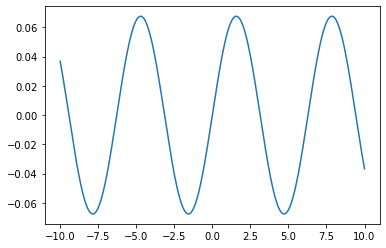

In [56]:
plt.plot(x_num, R1_ar)
print(np.max(R1_ar))

0.06750997971309534


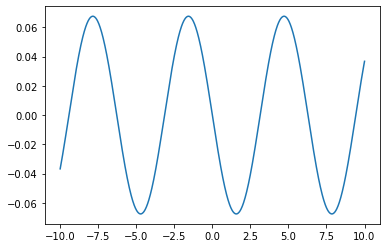

In [57]:
plt.plot(x_num, E1_ar)
print(np.max(E1_ar))

0.03375498985654767


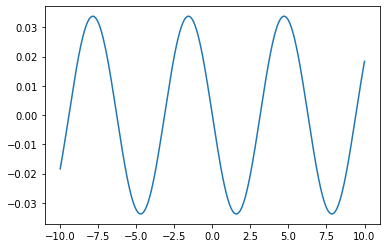

In [58]:
plt.plot(x_num, E2_ar)
print(np.max(E2_ar))

0.030383991536207113


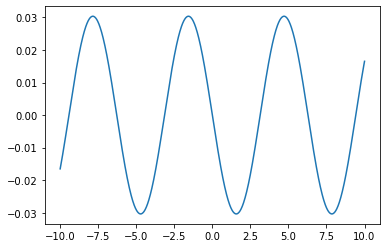

In [59]:
plt.plot(x_num, E31_ar)
print(np.max(E31_ar))

-0.003038312822987326


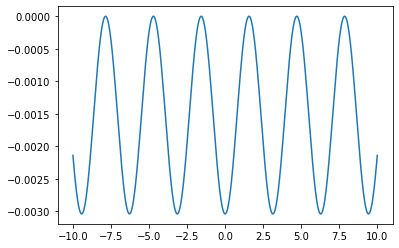

In [60]:
plt.plot(x_num, E32_ar)
print(np.min(E32_ar))

* Peak values calculated in deal.II are: $E_1 = 0.0130781$, $E_{31} = 0.00558595$, $E_{32} = 0.000430777$ where the last is the minimum magnitude (because the maximum is just a few orders of magnitude closer to zero).
* These are each about 

## Print $L_3$ altogether to use autodiff

In [61]:
factor(E31[0], (phi_i.diff(x), phi_i.diff(y)))

⎛             ∂                       ∂                         ∂             
⎜- 2⋅Q₁(x, y)⋅──(Q₁(x, y)) - Q₁(x, y)⋅──(Q₄(x, y)) - 2⋅Q₂(x, y)⋅──(Q₁(x, y)) -
⎝             ∂x                      ∂x                        ∂y            

          ∂           ⎞ ∂                 ⎛             ∂                     
 Q₂(x, y)⋅──(Q₄(x, y))⎟⋅──(\phiᵢ(x, y)) + ⎜- 2⋅Q₂(x, y)⋅──(Q₁(x, y)) - Q₂(x, y
          ∂y          ⎠ ∂x                ⎝             ∂x                    

  ∂                         ∂                       ∂           ⎞ ∂           
)⋅──(Q₄(x, y)) - 2⋅Q₄(x, y)⋅──(Q₁(x, y)) - Q₄(x, y)⋅──(Q₄(x, y))⎟⋅──(\phiᵢ(x, 
  ∂x                        ∂y                      ∂y          ⎠ ∂y          

   
y))
   

In [62]:
E32[0]

⎛                2                                             2              
⎜  ⎛∂           ⎞    ∂            ∂              ⎛∂           ⎞    ⎛∂         
⎜- ⎜──(Q₁(x, y))⎟  - ──(Q₁(x, y))⋅──(Q₄(x, y)) - ⎜──(Q₂(x, y))⎟  - ⎜──(Q₃(x, y
⎝  ⎝∂x          ⎠    ∂x           ∂x             ⎝∂x          ⎠    ⎝∂x        

   2                 2                 2⎞            
  ⎞    ⎛∂           ⎞    ⎛∂           ⎞ ⎟            
))⎟  - ⎜──(Q₄(x, y))⎟  - ⎜──(Q₅(x, y))⎟ ⎟⋅\phiᵢ(x, y)
  ⎠    ⎝∂x          ⎠    ⎝∂x          ⎠ ⎠            

In [63]:
assign_string = "    cell_rhs(i) +=\n"
# alen = len(assign_string)
alen = 8
space_str = ' '*alen
for i in range(vec_dim):
    if i == 0:
        print("if (component_i == {})".format(i))
    else:
        print("else if (component_i == {})".format(i))
        
    print(assign_string, end="")
    print(space_str + "(\n", end="")
    
    print_term(simplify(- dt * L3 * (E31[i] + E32[i])), alen)
    print(space_str, ')', sep='')
    print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0)
    cell_rhs(i) +=
        (
         (L3*dt*(((dQ[q][0][0] 
          + dQ[q][3][0])*Q_vec[q][0] + (dQ[q][0][1] + dQ[q][3][1])*Q_vec[q][1]) * fe_values.shape_grad(i, q)[0] 
          + ((dQ[q][0][0] + dQ[q][3][0])*Q_vec[q][1] + (dQ[q][0][1] + dQ[q][3][1])*Q_vec[q][3]) * fe_values.shape_grad(i, q)[1] 
          + (Q_vec[q][0]*dQ[q][0][0] + Q_vec[q][1]*dQ[q][0][1]) * fe_values.shape_grad(i, q)[0] 
          + (Q_vec[q][1]*dQ[q][0][0] + Q_vec[q][3]*dQ[q][0][1]) * fe_values.shape_grad(i, q)[1] + (dQ[q][0][0]*dQ[q][0][0] + dQ[q][0][0]*dQ[q][3][0] + dQ[q][1][0]*dQ[q][1][0] + dQ[q][2][0]*dQ[q][2][0] + dQ[q][3][0]*dQ[q][3][0] + dQ[q][4][0]*dQ[q][4][0])
          * fe_values.shape_value(i, q)))
        )
        * fe_values.JxW(q);
else if (component_i == 1)
    cell_rhs(i) +=
        (
         (L3*dt*(2*(Q_vec[q][0]*dQ[q][1][0] 
          + Q_vec[q][1]*dQ[q][1][1]) * fe_values.shape_grad(i, q)[0] 
          + 2*(Q_vec[q][1]*dQ[q][1][0] + Q_vec[q][3]*dQ[q][1][1]) * fe_va

In [64]:
assign_string = "    cell_rhs(i) +=\n"
# alen = len(assign_string)
alen = 8
space_str = ' '*alen
for i in range(vec_dim):
    if i == 0:
        print("if (component_i == {})".format(i))
    else:
        print("else if (component_i == {})".format(i))
        
    print(assign_string, end="")
    print(space_str + "(\n", end="")
    
    print_term(simplify(- dt * L3 * (E31[i])), alen)
    print(space_str, ')', sep='')
    print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0)
    cell_rhs(i) +=
        (
         (L3*dt*(((dQ[q][0][0] 
          + dQ[q][3][0])*Q_vec[q][0] + (dQ[q][0][1] + dQ[q][3][1])*Q_vec[q][1]) * fe_values.shape_grad(i, q)[0] 
          + ((dQ[q][0][0] + dQ[q][3][0])*Q_vec[q][1] + (dQ[q][0][1] + dQ[q][3][1])*Q_vec[q][3]) * fe_values.shape_grad(i, q)[1] 
          + (Q_vec[q][0]*dQ[q][0][0] + Q_vec[q][1]*dQ[q][0][1]) * fe_values.shape_grad(i, q)[0] 
          + (Q_vec[q][1]*dQ[q][0][0] + Q_vec[q][3]*dQ[q][0][1]) * fe_values.shape_grad(i, q)[1]))
        )
        * fe_values.JxW(q);
else if (component_i == 1)
    cell_rhs(i) +=
        (
         (2*L3*dt*((Q_vec[q][0]*dQ[q][1][0] 
          + Q_vec[q][1]*dQ[q][1][1]) * fe_values.shape_grad(i, q)[0] 
          + (Q_vec[q][1]*dQ[q][1][0] + Q_vec[q][3]*dQ[q][1][1]) * fe_values.shape_grad(i, q)[1]))
        )
        * fe_values.JxW(q);
else if (component_i == 2)
    cell_rhs(i) +=
        (
         (2*L3*dt*((Q_vec[q][0]*dQ[q][2][0] 
          + Q_vec[q][1]*dQ[q][2][1

In [65]:
assign_string = "    cell_rhs(i) +=\n"
# alen = len(assign_string)
alen = 8
space_str = ' '*alen
for i in range(vec_dim):
    if i == 0:
        print("if (component_i == {})".format(i))
    else:
        print("else if (component_i == {})".format(i))
        
    print(assign_string, end="")
    print(space_str + "(\n", end="")
    
    print_term(simplify(- dt * L3 * (E32[i])), alen)
    print(space_str, ')', sep='')
    print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0)
    cell_rhs(i) +=
        (
         (L3*dt*(dQ[q][0][0]*dQ[q][0][0] + dQ[q][0][0]*dQ[q][3][0] + dQ[q][1][0]*dQ[q][1][0] + dQ[q][2][0]*dQ[q][2][0] + dQ[q][3][0]*dQ[q][3][0] + dQ[q][4][0]*dQ[q][4][0])
          * fe_values.shape_value(i, q))
        )
        * fe_values.JxW(q);
else if (component_i == 1)
    cell_rhs(i) +=
        (
         (L3*dt*((dQ[q][0][0] + dQ[q][3][0])*(dQ[q][0][1] + dQ[q][3][1]) + dQ[q][0][0]*dQ[q][0][1] + 2*dQ[q][1][0]*dQ[q][1][1] + 2*dQ[q][2][0]*dQ[q][2][1] + dQ[q][3][0]*dQ[q][3][1] + 2*dQ[q][4][0]*dQ[q][4][1])
          * fe_values.shape_value(i, q))
        )
        * fe_values.JxW(q);
else if (component_i == 2)
    cell_rhs(i) +=
        (
        )
        * fe_values.JxW(q);
else if (component_i == 3)
    cell_rhs(i) +=
        (
         (L3*dt*(dQ[q][0][1]*dQ[q][0][1] + dQ[q][0][1]*dQ[q][3][1] + dQ[q][1][1]*dQ[q][1][1] + dQ[q][2][1]*dQ[q][2][1] + dQ[q][3][1]*dQ[q][3][1] + dQ[q][4][1]*dQ[q][4][1])
          * fe_values.shape_val

## Print $L_3$ analytic to test against auto-diff

In [68]:
assign_string = "    cell_matrix(i, j) +=\n"
# alen = len(assign_string)
alen = 12
space_str = ' ' * alen

term_list = [-simplify(dt * L3 * (dE31 + dE32))]
for i in range(vec_dim):
    for j in range(vec_dim):
        if (i == 0) and (j == 0):
            print("if (component_i == {} && component_j == {})".format(i, j))
        else:
            print("else if (component_i == {} && component_j == {})".format(i, j))

        print(assign_string, end="")
        print(space_str + "(\n", end="")
        
        nonzero_term_list = []
        for term in term_list:
            if not (term[i, j] == 0):
                nonzero_term_list.append(term)
        
        first_term = True
        for k, term in enumerate(nonzero_term_list):
            print_term(term[i, j], alen)
            first_term = False
            if not k == (len(nonzero_term_list) - 1):
                print(space_str, '+')

        print(space_str + ")")
        print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0 && component_j == 0)
    cell_matrix(i, j) +=
            (
             (2*L3*dt*(2*(Q_vec[q][1]*fe_values.shape_grad(j, q)[0] 
              + Q_vec[q][3] * fe_values.shape_grad(j, q)[1])*fe_values.shape_grad(i, q)[1] + ((dQ[q][0][0] + dQ[q][3][0])
              * fe_values.shape_value(j, q) 
              + Q_vec[q][0] * fe_values.shape_grad(j, q)[0] 
              + Q_vec[q][1] * fe_values.shape_grad(j, q)[1])*fe_values.shape_grad(i, q)[0] 
              + (Q_vec[q][0] * fe_values.shape_grad(j, q)[0] 
              + Q_vec[q][1] * fe_values.shape_grad(j, q)[1] 
              + fe_values.shape_value(j, q)*dQ[q][0][0]) * fe_values.shape_grad(i, q)[0]))
            )
            * fe_values.JxW(q);
else if (component_i == 0 && component_j == 1)
    cell_matrix(i, j) +=
            (
             (2*L3*dt*(2*dQ[q][0][0]*fe_values.shape_grad(i, q)[1] 
              + 2*dQ[q][0][1] * fe_values.shape_grad(i, q)[0] 
              + dQ[q][3][0] * fe_values.shape_grad(i,

In [66]:
assign_string = "    cell_matrix(i, j) +=\n"
# alen = len(assign_string)
alen = 12
space_str = ' ' * alen

term_list = [-simplify(dt * L3 * (dE31))]
for i in range(vec_dim):
    for j in range(vec_dim):
        if (i == 0) and (j == 0):
            print("if (component_i == {} && component_j == {})".format(i, j))
        else:
            print("else if (component_i == {} && component_j == {})".format(i, j))

        print(assign_string, end="")
        print(space_str + "(\n", end="")
        
        nonzero_term_list = []
        for term in term_list:
            if not (term[i, j] == 0):
                nonzero_term_list.append(term)
        
        first_term = True
        for k, term in enumerate(nonzero_term_list):
            print_term(term[i, j], alen)
            first_term = False
            if not k == (len(nonzero_term_list) - 1):
                print(space_str, '+')

        print(space_str + ")")
        print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0 && component_j == 0)
    cell_matrix(i, j) +=
            (
             (L3*dt*(2*(Q_vec[q][1]*fe_values.shape_grad(j, q)[0] 
              + Q_vec[q][3] * fe_values.shape_grad(j, q)[1])*fe_values.shape_grad(i, q)[1] + ((dQ[q][0][0] + dQ[q][3][0])
              * fe_values.shape_value(j, q) 
              + Q_vec[q][0] * fe_values.shape_grad(j, q)[0] 
              + Q_vec[q][1] * fe_values.shape_grad(j, q)[1])*fe_values.shape_grad(i, q)[0] 
              + (Q_vec[q][0] * fe_values.shape_grad(j, q)[0] 
              + Q_vec[q][1] * fe_values.shape_grad(j, q)[1] 
              + fe_values.shape_value(j, q)*dQ[q][0][0]) * fe_values.shape_grad(i, q)[0]))
            )
            * fe_values.JxW(q);
else if (component_i == 0 && component_j == 1)
    cell_matrix(i, j) +=
            (
             (L3*dt*(2*dQ[q][0][0]*fe_values.shape_grad(i, q)[1] 
              + 2*dQ[q][0][1] * fe_values.shape_grad(i, q)[0] 
              + dQ[q][3][0] * fe_values.shape_grad(i, q)[

In [70]:
assign_string = "    cell_matrix(i, j) +=\n"
# alen = len(assign_string)
alen = 12
space_str = ' ' * alen

term_list = [-simplify(dt * L3 * (dE32))]
for i in range(vec_dim):
    for j in range(vec_dim):
        if (i == 0) and (j == 0):
            print("if (component_i == {} && component_j == {})".format(i, j))
        else:
            print("else if (component_i == {} && component_j == {})".format(i, j))

        print(assign_string, end="")
        print(space_str + "(\n", end="")
        
        nonzero_term_list = []
        for term in term_list:
            if not (term[i, j] == 0):
                nonzero_term_list.append(term)
        
        first_term = True
        for k, term in enumerate(nonzero_term_list):
            print_term(term[i, j], alen)
            first_term = False
            if not k == (len(nonzero_term_list) - 1):
                print(space_str, '+')

        print(space_str + ")")
        print(space_str, '* fe_values.JxW(q);', sep='')

if (component_i == 0 && component_j == 0)
    cell_matrix(i, j) +=
            (
             (L3*dt*(2*dQ[q][0][0] + dQ[q][3][0])
              * fe_values.shape_value(i, q)*fe_values.shape_grad(j, q)[0])
            )
            * fe_values.JxW(q);
else if (component_i == 0 && component_j == 1)
    cell_matrix(i, j) +=
            (
             (2*L3*dt
              * fe_values.shape_value(i, q)*dQ[q][1][0]*fe_values.shape_grad(j, q)[0])
            )
            * fe_values.JxW(q);
else if (component_i == 0 && component_j == 2)
    cell_matrix(i, j) +=
            (
             (2*L3*dt
              * fe_values.shape_value(i, q)*dQ[q][2][0]*fe_values.shape_grad(j, q)[0])
            )
            * fe_values.JxW(q);
else if (component_i == 0 && component_j == 3)
    cell_matrix(i, j) +=
            (
             (L3*dt*(dQ[q][0][0] + 2*dQ[q][3][0])
              * fe_values.shape_value(i, q)*fe_values.shape_grad(j, q)[0])
            )
            * fe_values.JxW(q);
else if (